In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade google-colab


In [ ]:
import pandas as pd
import os
import numpy as np

# LETTURA DATI TRAINING

In [ ]:
def leggi_dati_lista(nome_cartella):
  lista = []
  for filename in sorted(os.listdir(nome_cartella)):
    # Costruisci il percorso completo del file
    percorso_file = os.path.join(nome_cartella, filename)

    # Leggi solo la terza colonna del file CSV in un DataFrame e assegna un nome dinamico
    df= pd.read_csv(percorso_file, usecols=[0])

    lista.append(df["acc_X"].values)

  return lista

In [ ]:
cartella_train_0 = r'/content/drive/MyDrive/Progetto_manutenzione/file_cut_training/Pitting_degradation_level_0 (Healthy)'
cartella_train_1 = r'/content/drive/MyDrive/Progetto_manutenzione/file_cut_training/Pitting_degradation_level_1'
cartella_train_2 = r'/content/drive/MyDrive/Progetto_manutenzione/file_cut_training/Pitting_degradation_level_2'
cartella_train_3 = r'/content/drive/MyDrive/Progetto_manutenzione/file_cut_training/Pitting_degradation_level_3'
cartella_train_4 = r'/content/drive/MyDrive/Progetto_manutenzione/file_cut_training/Pitting_degradation_level_4'
cartella_train_5 = r'/content/drive/MyDrive/Progetto_manutenzione/file_cut_training/Pitting_degradation_level_5'
cartella_train_6 = r'/content/drive/MyDrive/Progetto_manutenzione/file_cut_training/Pitting_degradation_level_6'

In [ ]:
x_train_list_0 = leggi_dati_lista(cartella_train_0)
x_train_list_1 = leggi_dati_lista(cartella_train_1)
x_train_list_2 = leggi_dati_lista(cartella_train_2)
x_train_list_3 = leggi_dati_lista(cartella_train_3)
x_train_list_4 = leggi_dati_lista(cartella_train_4)
x_train_list_5 = leggi_dati_lista(cartella_train_5)
x_train_list_6 = leggi_dati_lista(cartella_train_6)

print('Dati classe 0: ' + str(len(x_train_list_0)))
print('Dati classe 1: ' + str(len(x_train_list_1)))
print('Dati classe 2: ' + str(len(x_train_list_2)))
print('Dati classe 3: ' + str(len(x_train_list_3)))
print('Dati classe 4: ' + str(len(x_train_list_4)))
print('Dati classe 5: ' + str(len(x_train_list_5)))
print('Dati classe 6: ' + str(len(x_train_list_6)))

Dati classe 0: 1619
Dati classe 1: 1659
Dati classe 2: 1626
Dati classe 3: 1506
Dati classe 4: 1776
Dati classe 5: 1584
Dati classe 6: 1695


In [ ]:
# Creo lista di tutti i dati di train ignorando le classi 3 e 6
x_train_list = x_train_list_0 + x_train_list_1 + x_train_list_2 + x_train_list_4 + x_train_list_5
x_train = np.asarray(x_train_list)

In [ ]:
lista_etichette_train = []

# Creo la lista  delle erichette di train ignorando le etichette dei dati di classe 3 e 6

lista_etichette_train.extend([0] * len(x_train_list_0))
lista_etichette_train.extend([1] * len(x_train_list_1))
lista_etichette_train.extend([2] * len(x_train_list_2))
#lista_etichette_train.extend([3] * len(x_train_list_3))
lista_etichette_train.extend([3] * len(x_train_list_4)) # etichetta 3 significa 4
lista_etichette_train.extend([4] * len(x_train_list_5)) # etichetta 4 significa 5
#lista_etichette_train.extend([6] * len(x_train_list_6))

print('Numero dati totali train: ' + str(len(lista_etichette_train)))

Numero dati totali train: 8264


In [ ]:
import tensorflow as tf

y_train_integer = np.asarray(lista_etichette_train)
y_train = tf.keras.utils.to_categorical(y_train_integer)

# MODELLO E TRAINING CNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Add
import tensorflow as tf

# Input Layer
input_layer = Input(shape=(20000, 1))

# Separable_Conv1D_1
conv1 =  SeparableConv1D(32, kernel_size=3, strides=1, padding='same', activation='relu')(input_layer)
conv1_mp = MaxPooling1D(pool_size=2, padding='same')(conv1)

# Separable_Conv1D_2
conv2 =  SeparableConv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(conv1_mp)
conv2_mp = MaxPooling1D(pool_size=2, padding='same')(conv2)

# Separable_Conv1D_3
conv3 =  SeparableConv1D(64, kernel_size=3, strides=4, padding='same', activation='relu')(input_layer)

# Residual Layer 1
residual1 = Add()([conv2_mp, conv3])


# Residual Layer 2
sep_conv_4 = SeparableConv1D(128, kernel_size=3, activation='relu', padding='same')(residual1)
sep_conv_5 = SeparableConv1D(128, kernel_size=3, activation='relu', padding='same')(sep_conv_4)
sep_conv6 = SeparableConv1D(128, kernel_size=3, strides=4, activation='relu', padding='same')(input_layer)
residual2= Add()([sep_conv_5, sep_conv6])


# Global Max Pooling
global_max_pooling = GlobalMaxPooling1D()(residual2)

# Dense Layer
dense_layer = Dense(100, activation='relu')(global_max_pooling)

# Softmax Layer
softmax_layer = Dense(5, activation='softmax')(dense_layer)

# Creazione del modello
model = Model(inputs=input_layer, outputs=softmax_layer)


optimizer = tf.keras.optimizers.experimental.RMSprop(
    learning_rate=0.002,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07
)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

# Visualizzazione della struttura della rete
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20000, 1)]           0         []                            
                                                                                                  
 separable_conv1d (Separabl  (None, 20000, 32)            67        ['input_1[0][0]']             
 eConv1D)                                                                                         
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 10000, 32)            0         ['separable_conv1d[0][0]']    
 D)                                                                                               
                                                                                              

In [ ]:
model.fit(x_train,y_train, epochs=60)

Epoch 1/20
259/259 [==============================] - 18s 69ms/step - loss: 0.1273 - categorical_accuracy: 0.9552
Epoch 2/20
259/259 [==============================] - 19s 73ms/step - loss: 0.1238 - categorical_accuracy: 0.9560
Epoch 3/20
259/259 [==============================] - 19s 73ms/step - loss: 0.1244 - categorical_accuracy: 0.9537
Epoch 4/20
259/259 [==============================] - 19s 72ms/step - loss: 0.1291 - categorical_accuracy: 0.9552
Epoch 5/20
259/259 [==============================] - 19s 72ms/step - loss: 0.1176 - categorical_accuracy: 0.9589
Epoch 6/20
259/259 [==============================] - 19s 72ms/step - loss: 0.1192 - categorical_accuracy: 0.9587
Epoch 7/20
259/259 [==============================] - 18s 69ms/step - loss: 0.1090 - categorical_accuracy: 0.9606
Epoch 8/20
259/259 [==============================] - 18s 70ms/step - loss: 0.1073 - categorical_accuracy: 0.9618
Epoch 9/20
259/259 [==============================] - 19s 73ms/step - loss: 0.1045 - cat

# LETTURA DATI TEST

In [ ]:
cartella_test_0 = r'/content/drive/MyDrive/Progetto_manutenzione/hold_out_test/Pitting_degradation_level_0 (Healthy)'
cartella_test_1 = r'/content/drive/MyDrive/Progetto_manutenzione/hold_out_test/Pitting_degradation_level_1'
cartella_test_2 = r'/content/drive/MyDrive/Progetto_manutenzione/hold_out_test/Pitting_degradation_level_2'
cartella_test_3 = r'/content/drive/MyDrive/Progetto_manutenzione/hold_out_test/Pitting_degradation_level_3'
cartella_test_4 = r'/content/drive/MyDrive/Progetto_manutenzione/hold_out_test/Pitting_degradation_level_4'
cartella_test_5 = r'/content/drive/MyDrive/Progetto_manutenzione/hold_out_test/Pitting_degradation_level_5'
cartella_test_6 = r'/content/drive/MyDrive/Progetto_manutenzione/hold_out_test/Pitting_degradation_level_6'

In [ ]:
x_test_list_0 = leggi_dati_lista(cartella_test_0)
x_test_list_1 = leggi_dati_lista(cartella_test_1)
x_test_list_2 = leggi_dati_lista(cartella_test_2)
x_test_list_3 = leggi_dati_lista(cartella_test_3)
x_test_list_4 = leggi_dati_lista(cartella_test_4)
x_test_list_5 = leggi_dati_lista(cartella_test_5)
x_test_list_6 = leggi_dati_lista(cartella_test_6)

print('DATI DI TEST')
print('Dati classe 0: ' + str(len(x_test_list_0)))
print('Dati classe 1: ' + str(len(x_test_list_1)))
print('Dati classe 2: ' + str(len(x_test_list_2)))
print('Dati classe 3 (ignorati): ' + str(len(x_test_list_3)))
print('Dati classe 4 (etichetta 3): ' + str(len(x_test_list_4)))
print('Dati classe 5 (etichetta 4): ' + str(len(x_test_list_5)))
print('Dati classe 6 (ignorati): ' + str(len(x_test_list_6)))

DATI DI TEST
Dati classe 0: 161
Dati classe 1: 157
Dati classe 2: 166
Dati classe 3 (ignorati): 173
Dati classe 4 (etichetta 3): 156
Dati classe 5 (etichetta 4): 156
Dati classe 6 (ignorati): 156


In [ ]:
# Creo lista di tutti i dati di test ignorando le classi 3 e 6
x_test_list = x_test_list_0 + x_test_list_1 + x_test_list_2 + x_test_list_4 + x_test_list_5
x_test = np.asarray(x_test_list)

In [ ]:
print('Numero dati test utilizzati: ' + str(len(x_test_list)))

Numero dati test utilizzati: 796


In [ ]:
lista_etichette_test = []

# Creo la lista  delle erichette di train ignorando le etichette dei dati di classe 3 e 6

lista_etichette_test.extend([0] * len(x_test_list_0))
lista_etichette_test.extend([1] * len(x_test_list_1))
lista_etichette_test.extend([2] * len(x_test_list_2))
#lista_etichette_test.extend([3] * len(x_test_list_3))
lista_etichette_test.extend([3] * len(x_test_list_4)) # etichetta 3 significa 4
lista_etichette_test.extend([4] * len(x_test_list_5)) # etichetta 4 significa 5
#lista_etichette_test.extend([6] * len(x_test_list_6))

print('Numero dati totali test: ' + str(len(lista_etichette_test)))

y_test_integer = np.asarray(lista_etichette_test)
y_test = tf.keras.utils.to_categorical(y_test_integer)

Numero dati totali test: 796


# TEST DEL MODELLO CNN

In [ ]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

25/25 [==============================] - 1s 31ms/step - loss: 0.3537 - categorical_accuracy: 0.9121
[0.35367730259895325, 0.9120603203773499]


In [ ]:
prediction = model.predict(x_test)

25/25 [==============================] - 1s 27ms/step


In [ ]:
# Trova l'indice della classe con la probabilità più alta per ciascun vettore di probabilità
indici_classi_predette = np.argmax(prediction, axis=1)
# Crea la matrice one-hot
matrice_one_hot = np.eye(prediction.shape[1])[indici_classi_predette]

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test,matrice_one_hot, average='macro'))
print(recall_score(y_test,matrice_one_hot, average='macro'))

0.9183825896325896
0.911492855026669


In [ ]:
from sklearn.metrics import confusion_matrix
# Converte la matrice one-hot in etichette predette
etichette_predette = np.argmax(matrice_one_hot, axis=1)

# Converte y_test in etichette reali
etichette_reali = np.argmax(y_test, axis=1)

# Calcola la matrice di confusione
matrice_confusione = confusion_matrix(etichette_reali, etichette_predette)

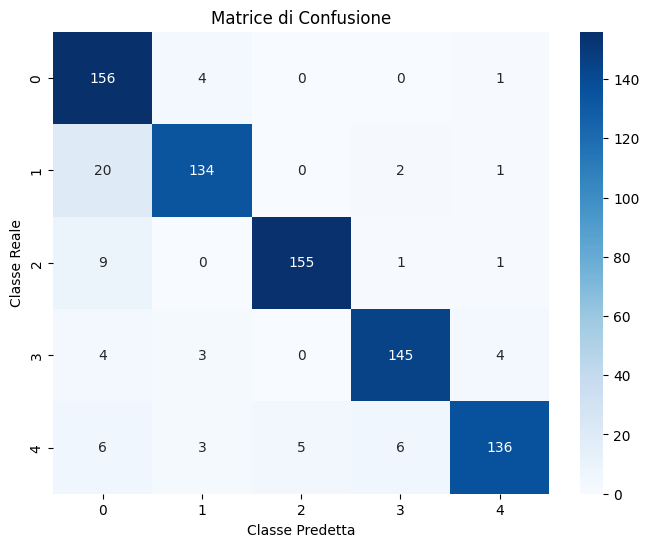

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot della matrice di confusione utilizzando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(matrice_confusione, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Reale')
plt.title('Matrice di Confusione')
plt.show()


In [ ]:
model.save_weights('CNN.h5')

# TEST CON TUTTI LE CLASSI

In [ ]:
# Creo le x di test prendendo i dati di tutte le classi
x_test_list_all = x_test_list_0 + x_test_list_1 + x_test_list_2 + x_test_list_3 + x_test_list_4 + x_test_list_5 + x_test_list_6
x_test_all = np.asarray(x_test_list_all)

In [ ]:
print('Numero dati test totali: ' + str(len(x_test_list_all)))

Numero dati test totali: 1125


In [ ]:
predizioni_per_tutte_le_classi = model.predict(x_test_all)

36/36 [==============================] - 1s 34ms/step


In [ ]:
np.savetxt('predizioni_dati_test.csv', predizioni_per_tutte_le_classi, delimiter=',')

In [ ]:
my_data = np.genfromtxt('/content/predizioni_dati_test.csv', delimiter=',')

In [ ]:
print(my_data.shape)

(1125, 5)


# TRAFORMATA DI FOURIER

In [ ]:
import statistics

#numero di campioni acquisiti al secondo
sample_rate = 20480

def minmax_norm(df_input):
  mean = statistics.mean(df_input)
  var = statistics.variance(df_input)
  return (df_input - mean) / (var)

def trasf_fourier(dataframe):
    trasformata_fourier = np.fft.fft(dataframe)
    #frequencies = np.fft.fftfreq(len(trasformata_fourier), d=1/sample_rate)
    #ampiezze_importanti = np.abs(trasformata_fourier)
    #prime_1000_ampiezze = np.sort(ampiezze_importanti.real)[-1000:]
    #prime_1000_ampiezze_norm = minmax_norm(prime_1000_ampiezze)
    #prime_1000_frequenze = frequencies[np.argsort(ampiezze_importanti)[-2000::2]]
    #prime_1000_frequenze_norm = minmax_norm(np.abs(prime_1000_frequenze))
    #print(prime_1000_frequenze_norm)
    #return prime_1000_frequenze_norm
    return minmax_norm(np.real(trasformata_fourier))

In [ ]:
#commento
ft_train_list = []
for vettore in x_train:
  ft_train_list.append(trasf_fourier(vettore))

ft_train = np.asarray(ft_train_list)


In [ ]:
print(trasf_fourier(x_train[0]))

In [ ]:
print(ft_train[0:50])
print(ft_train.shape)

[[-0.14990294 -0.04959235  0.04427699 ... -0.00578588  0.04427699
  -0.04959235]
 [ 0.11405049  0.03124054 -0.03436506 ... -0.02368812 -0.03436506
   0.03124054]
 [-0.07009451  0.02554628  0.00127825 ... -0.00835055  0.00127825
   0.02554628]
 ...
 [-0.15294157  0.20877209  0.19181214 ...  0.01681075  0.19181214
   0.20877209]
 [-0.81416889  0.13163803  0.11478557 ... -0.0078424   0.11478557
   0.13163803]
 [ 0.03475748 -0.23350159 -0.07081515 ...  0.00836389 -0.07081515
  -0.23350159]]
(8264, 20000)


# MODELLO E TRAINING AUTOENCODER

#Modello autoencoder CARLO

In [ ]:
#MODELLO CARLO
import tensorflow as tf

# Definizione dei parametri
input_size = 20000
hidden1_size = 1000
hidden2_size = 500
hidden3_size = 50

# Definizione della rete
class SparseAutoencoder(tf.keras.Model):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden1_size, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(weight_regularization)),
            tf.keras.layers.Dense(hidden2_size, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(weight_regularization)),
            tf.keras.layers.Dense(hidden3_size, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(weight_regularization))
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden2_size, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(weight_regularization)),
            tf.keras.layers.Dense(hidden1_size, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(weight_regularization)),
            tf.keras.layers.Dense(input_size, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(weight_regularization))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Definizione degli iperparametri
sparsity_target = 0.15
sparsity_weight = 3
learning_rate = 0.001
#impostato a mano
weight_regularization = 0.001

def sparse_autoencoder_loss(x, decoded_output):
    encoded_output = autoencoder.encoder(x)  # Chiamata all'encoder per ottenere encoded_output
    reconstruction_loss = tf.reduce_mean(tf.square(x - decoded_output))
    sparsity_loss = tf.reduce_mean(sparsity_weight * (sparsity_target * tf.math.log(sparsity_target / tf.reduce_mean(encoded_output)) + (1 - sparsity_target) * tf.math.log((1 - sparsity_target) / (1 - tf.reduce_mean(encoded_output)))))
    total_loss = reconstruction_loss + sparsity_loss
    return total_loss


# Creazione del modello
autoencoder = SparseAutoencoder()
# Compilazione del modello
autoencoder.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss=sparse_autoencoder_loss)

In [ ]:
autoencoder.build((None, input_size))  # Specifica la forma dell'input

In [ ]:
autoencoder.summary()

Model: "sparse_autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 50)                20526550  
                                                                 
 sequential_3 (Sequential)   (None, 20000)             20546500  
                                                                 
Total params: 41073050 (156.68 MB)
Trainable params: 41073050 (156.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
autoencoder.fit(ft_train, ft_train, epochs=40)

In [ ]:
# Codifica dei dati di input
encoded_data = autoencoder.encoder.predict(ft_train)


print("Encoded data shape:", encoded_data.shape)

In [ ]:
print(encoded_data)

In [ ]:
#qui ci sono i vettori di dimensione 50 da passare al cluster
lista_per_cluster = []

for item in encoded_data:
  lista_per_cluster.append(np.array(item))

lista_per_cluster = [arr.astype(float) for arr in lista_per_cluster]

print(lista_per_cluster[7000:8000])

In [ ]:
#trasformo lista in dataframe da 50 colonne e x mila righe
dataframe = pd.DataFrame()
for vettore in lista_per_cluster:
  row_df = pd.DataFrame([vettore])
  # Concatena il DataFrame della riga al DataFrame esistente
  dataframe = pd.concat([dataframe, row_df], ignore_index=True)
print(dataframe)

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns
#print(type(dataframe[1]))
#numerical_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns
#print(numerical_columns)

#metti il nostro df
corr = dataframe.corr()
print(corr)

#formato del testo
annot_kws = {"size": 8}

corr_filtered = corr[corr >= 0.8]
#print(corr_filtered)

# Disegna la heatmap utilizzando il DataFrame filtrato
sns.heatmap(corr_filtered, vmax=1, vmin=-1, square=True, annot=True, linewidths=.2, cbar=True)
plt.tight_layout()
#plt.savefig("../images/correlazione_player.png")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

k = 5

# inizializziamo l'algoritmo K-Means
kmeans = KMeans(n_clusters=k, random_state=42)

# eseguiamo l'addestramento del modello
#kmeans.fit(dataframe)
kmeans.fit(encoded_data)



In [ ]:
centroids = kmeans.cluster_centers_
print(centroids)

In [ ]:
#plt.scatter(dataframe[4], dataframe[6], color='red')
# Otteniamo le etichette dei cluster
labels = kmeans.labels_
dataframe_subset = dataframe.iloc[:]
print(labels[1618:1800])

# Creiamo lo scatter plot
#plt.figure(figsize=(10, 6))
#plt.scatter(dataframe_subset.iloc[:, 1], dataframe_subset.iloc[:, 2], c=labels[:], cmap='viridis', s=50, alpha=0.5)
#plt.title('Scatter Plot con Cluster (Primi 1600 punti)')
#plt.xlabel('Feature 4')
#plt.ylabel('Feature 6')
#plt.colorbar(label='Cluster')
#plt.show()

In [ ]:
print("cluster 0: "+ str(labels[1620:3240].tolist().count(0)))
print("cluster 1: "+ str(labels[1620:3240].tolist().count(1)))
print("cluster 2: "+ str(labels[1620:3240].tolist().count(2)))
print("cluster 3: "+ str(labels[1620:3240].tolist().count(3)))
print("cluster 4: "+ str(labels[1620:3240].tolist().count(4)))

In [ ]:
print("cluster 0: "+ str(labels[0:1619].tolist().count(0)))
print("cluster 1: "+ str(labels[0:1619].tolist().count(1)))
print("cluster 2: "+ str(labels[0:1619].tolist().count(2)))
print("cluster 3: "+ str(labels[0:1619].tolist().count(3)))
print("cluster 4: "+ str(labels[0:1619].tolist().count(4)))

# PROVA GRAFICA FFT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
vettore_classe_0 = np.asarray(x_train_list_0[100])
vettore_classe_1 = np.asarray(x_train_list_1[100])
vettore_classe_2 = np.asarray(x_train_list_2[100])
vettore_classe_3 = np.asarray(x_train_list_3[100])
vettore_classe_4 = np.asarray(x_train_list_4[100])
vettore_classe_5 = np.asarray(x_train_list_5[100])
vettore_classe_6 = np.asarray(x_train_list_6[100])

In [ ]:
Fs = 20480  # Frequenza di campionamento (Hz)
T = 1 / Fs  # Intervallo di campionamento

In [ ]:
freq = np.fft.fftfreq(len(vettore_classe_0), T)  # Calcola le frequenze corrispondenti, è indipendnente dal vettore di cui si fa la trasformata ma solo dalla sua lunghezza
print(len(freq))

20000


In [ ]:
def plot_fft(fft_result, frequenze):
  # Plot della FFT
  plt.figure(figsize=(10, 6))
  plt.plot(frequenze[:len(fft_result)//2], np.abs(fft_result)[:len(fft_result)//2])  # Visualizza solo la parte positiva della FFT
  plt.xlabel('Frequenza (Hz)')
  plt.ylabel('Ampiezza')
  plt.title('Trasformata di Fourier del Segnale')
  plt.grid(True)
  plt.show()

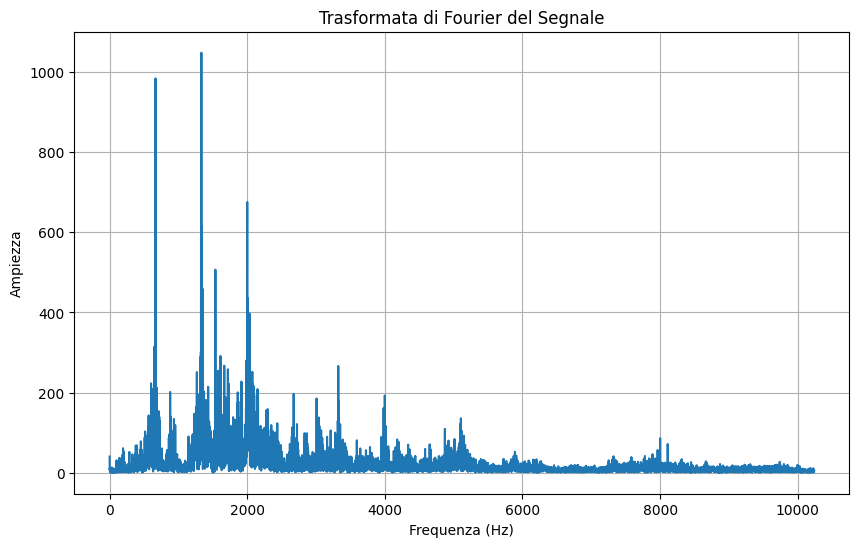

In [ ]:
plot_fft(np.fft.fft(x_train_list_0[0]), freq)

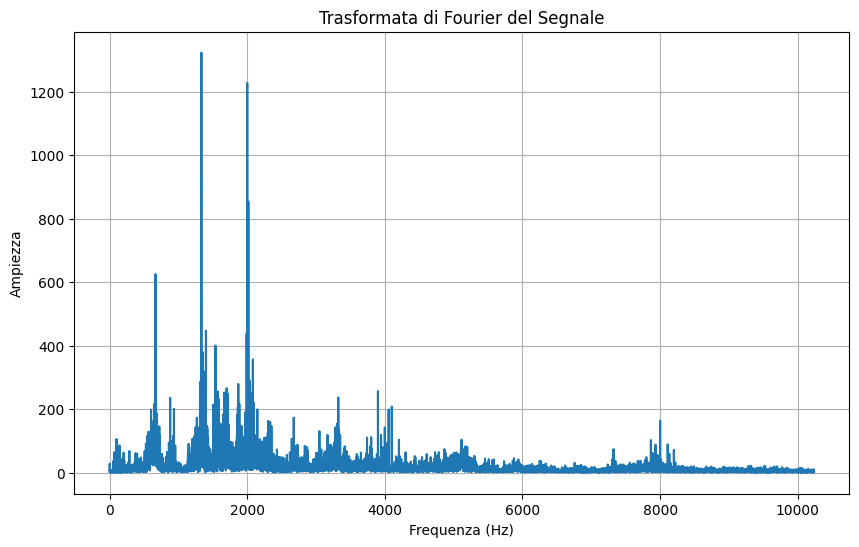

In [ ]:
plot_fft(np.fft.fft(x_train_list_1[0]), freq)

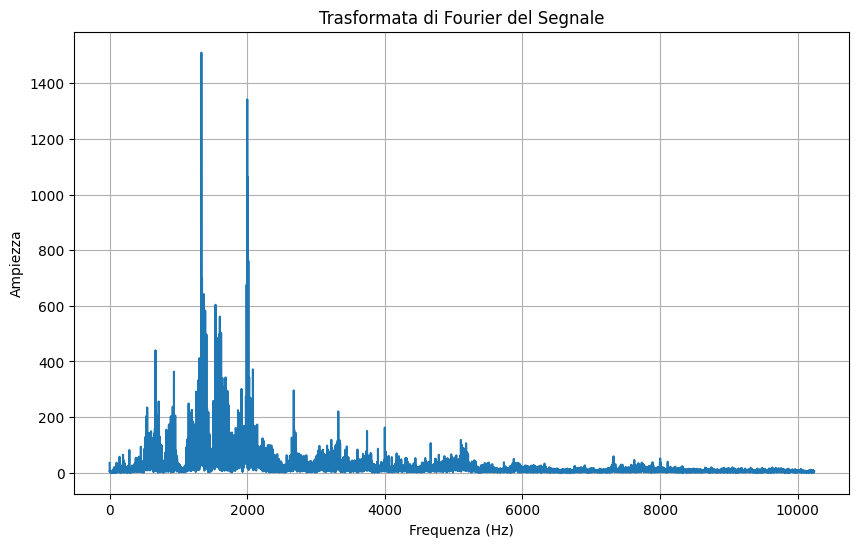

In [ ]:
plot_fft(np.fft.fft(x_train_list_2[0]), freq)

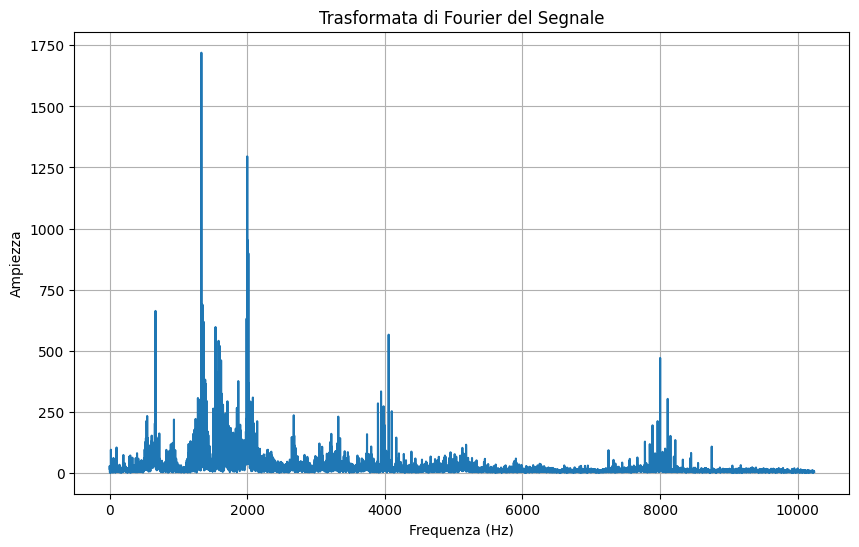

In [ ]:
plot_fft(np.fft.fft(x_train_list_3[0]), freq)

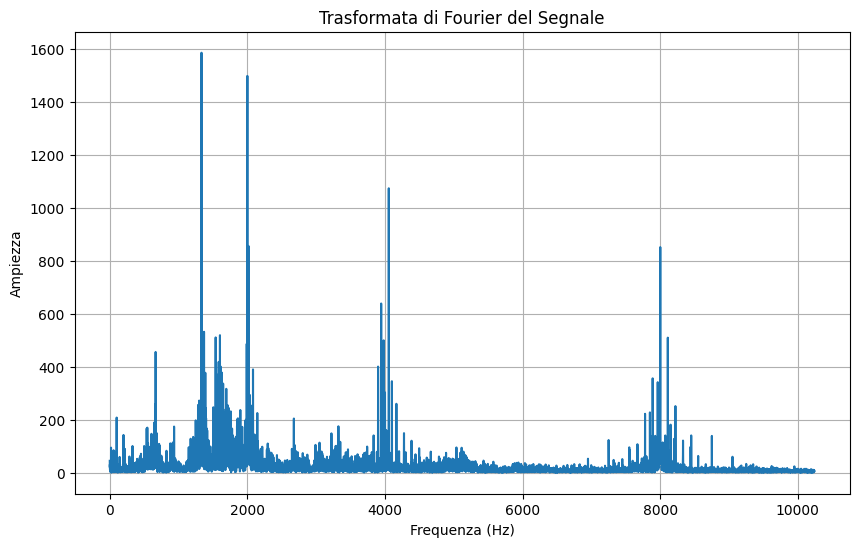

In [ ]:
plot_fft(np.fft.fft(x_train_list_4[0]), freq)

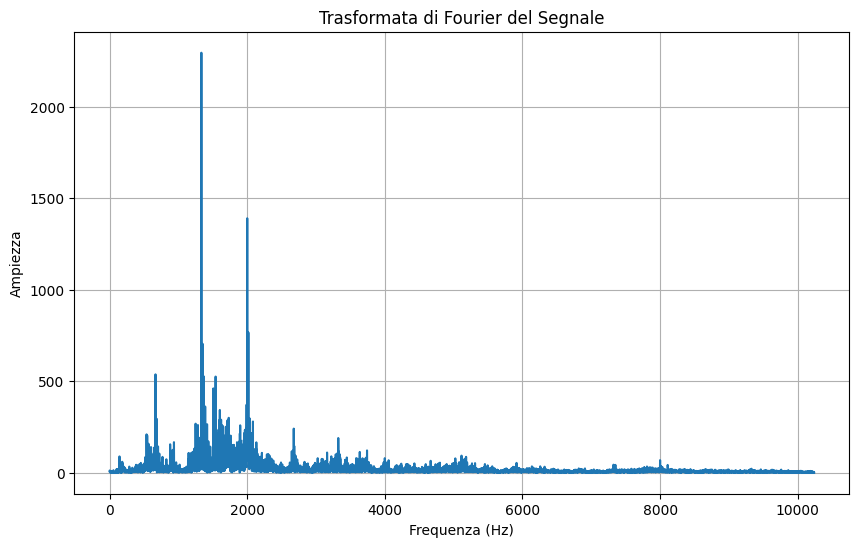

In [ ]:
plot_fft(np.fft.fft(x_train_list_5[0]), freq)

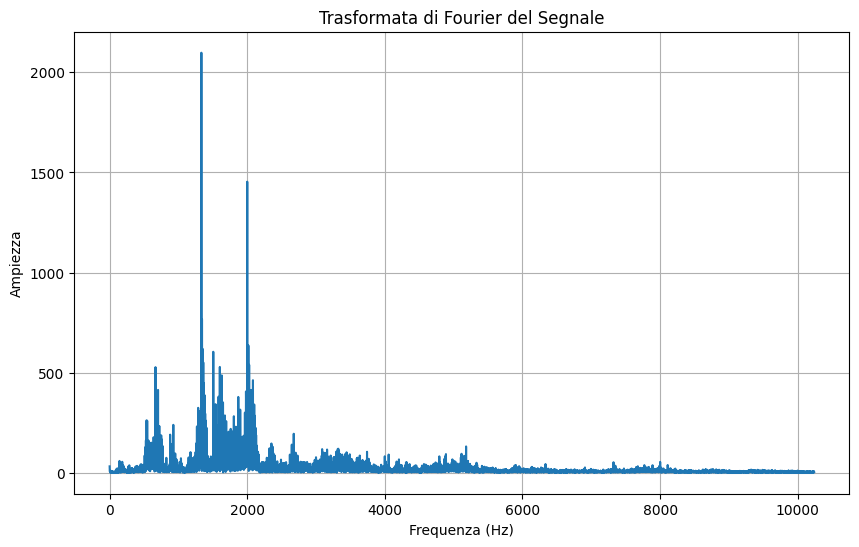

In [ ]:
plot_fft(np.fft.fft(x_train_list_6[0]), freq)